<a href="https://colab.research.google.com/github/eloigil/fast.ai_playground/blob/main/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.7MB/s 
     |████████████████████████████████| 194kB 14.0MB/s 
     |████████████████████████████████| 1.2MB 15.6MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/root/.fastai/data/mnist_sample')

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
# print(threes)
# print(sevens)

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
type(im3) #PIL is Pynthon Imaging Library

PIL.PngImagePlugin.PngImageFile

In [10]:
# Converting it to NumPy array
array(im3)[4:10,4:10] # the 4:10 is just selecting a part of the total array

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
# Converting it to PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22]) #pandas dataframe (cause it has background_gradient)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens] #convert all sevens to tensors
three_tensors = [tensor(Image.open(o)) for o in threes] #convert all threes to tensors
len(three_tensors),len(seven_tensors)

(6131, 6265)

torch.Size([28, 28])

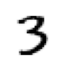

In [14]:
show_image(three_tensors[1]) #fast.ai command to display a tensor
three_tensors[1].shape

In [15]:
# funny note
print(type(three_tensors[1])) # python type says its a pytorch library tensor
print(three_tensors[1].type()) # type method shows the type of tensor

<class 'torch.Tensor'>
torch.ByteTensor


In [16]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [17]:
rank = len(stacked_threes.shape)
rank

3

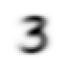

In [18]:
mean3 = stacked_threes.mean(0) # take the mean from the first axis
show_image(mean3);

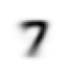

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

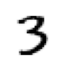

In [20]:
a_3 = stacked_threes[1]
show_image(a_3)

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 norm
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

## Computing Metrics Using Broadcasting

In [23]:
# doing the same before for the validation sets
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3) #process run once

tensor(0.1114)

In [25]:
# but we have to do the process for the entire valiation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
print('valid_3_tens shape:', valid_3_tens.shape)
print('mean3 shape:', mean3.shape)
valid_3_dist, valid_3_dist.shape
# it returned an array of 1010 values due to Broadcasting: when it finds different shapes it acts as if mean3 was copied 1010 times

valid_3_tens shape: torch.Size([1010, 28, 28])
mean3 shape: torch.Size([28, 28])


(tensor([0.1355, 0.1138, 0.1083,  ..., 0.1103, 0.1530, 0.1169]),
 torch.Size([1010]))

In [26]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [27]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [28]:
# we can broadcast the process into the entire set
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [29]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent SGD

In [30]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

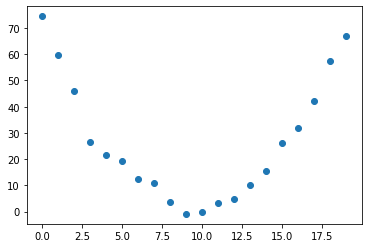

In [31]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [32]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [33]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt() # mean squared error

### 7 steps process

1. Initialize the parameters

In [34]:
params = torch.randn(3).requires_grad_() # initialize the parameters to random values, and tell PyTorch that we want to track their gradients

In [35]:
#hide
orig_params = params.clone()

2. Calculate the predictions

In [36]:
preds = f(time, params)

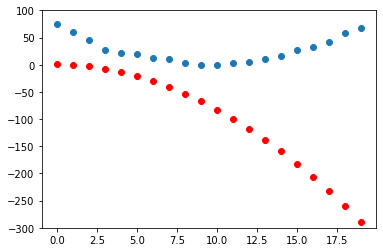

In [37]:
# how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)

3. Calculate the loss

In [38]:
loss = mse(preds, speed)
loss

tensor(160.6979, grad_fn=<SqrtBackward>)

4. Calculate the gradients

In [39]:
loss.backward()

In [40]:
params.grad * 1e-5 # 1e-5 learning rate

tensor([-1.6552e-03, -1.0640e-04, -7.8996e-06])

In [41]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

5. Step the weights

In [42]:
# update the parameters based on the gradients we just calculated
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [43]:
preds = f(time,params)
mse(preds, speed)

tensor(160.4228, grad_fn=<SqrtBackward>)

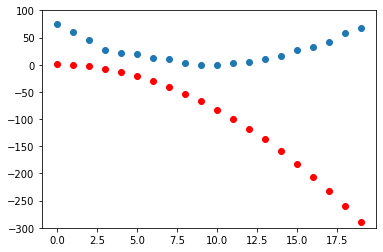

In [44]:
show_preds(preds)

6. Repeat the process

In [45]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds
for i in range(10): apply_step(params)

160.42279052734375
160.14772033691406
159.87269592285156
159.59768676757812
159.3227081298828
159.04774475097656
158.7728271484375
158.4979248046875
158.22305297851562
157.9481964111328


In [46]:
params = orig_params.detach().requires_grad_()

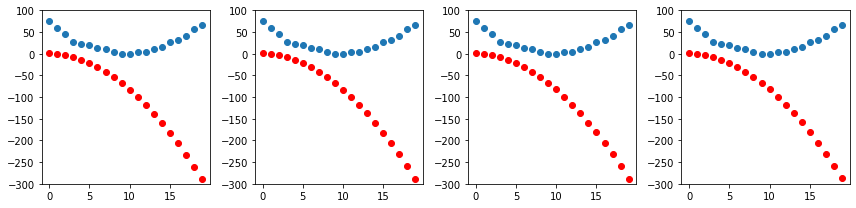

In [47]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()


7. stop


## The MNIST Loss Function

In [48]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) # view method reshapes the tensor (-1 is for all the list items)

In [49]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # label 1 for 3s and 0 for 7s
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [50]:
# create the training dataset
dset = list(zip(train_x,train_y))
x,y = dset[0] # a dataset is something you can index into and get back a tuple
x.shape,y

(torch.Size([784]), tensor([1]))

In [52]:
# do the same to create the validation dataset
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [57]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))

The function weights*pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0.

y=w*x+b; we still need the b

In [55]:
bias = init_params(1)



> jargon: **Parameters**: The weights and biases of a model. The weights are the w in the equation w*x+b, and the biases are the b in that equation.



In [58]:
# calculate a prediction for 1 image
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [59]:
# calculate predictions for all items with matrix multiplication (@)
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [70]:
#  check whether it's greater than 0. accuracy for each item can be calculated using broadcasting (no loops)
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [67]:
corrects.float().mean().item()

0.4912068545818329

##### sigmoid in loss function

In [79]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [80]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### Applying loss function

In [71]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [74]:
# a dataloader carn be created from a dataset
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [75]:
valid_dl = DataLoader(valid_dset, batch_size=256)

##### test with a mini batch

In [76]:
batch = train_x[:4]
batch.shape


torch.Size([4, 784])

In [77]:
preds = linear1(batch)
preds

tensor([[-15.0592],
        [ -6.4868],
        [-14.2646],
        [-11.4282]], grad_fn=<AddBackward0>)

In [81]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9996, grad_fn=<MeanBackward0>)

In [82]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-5.4572e-05), tensor([-0.0004]))

In [83]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [84]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0001), tensor([-0.0008]))